# Intro
Prepare the *Wine Spectator* Top 100 review set for training a text classifier model.
Reference: [Dataset Splitting Best Practices in Python](https://www.kdnuggets.com/2020/05/dataset-splitting-best-practices-python.html)

# Load the *Wine Spectator* Top 100 dataset

## File setup

In [1]:
# import and initialize main python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import libraries for file navigation
import os
import shutil
import glob
from pandas_ods_reader import read_ods

# import other libraries
import re # regular expressions
import string # working with text

# import ML libraries
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# import Pickle for ML model export
import pickle

In [2]:
# Ensure TensorFlow version is at least 2.4.0
print(tf.__version__)

2.4.1


## Load and explore the dataset

In [3]:
dataset_dir = './review_data'

In [4]:
os.listdir(dataset_dir)

['train', 'test', 'val']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['3', '4', '1', '2', '0']

In [6]:
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(test_dir)

['3', '4', '1', '2', '0']

In [7]:
val_dir = os.path.join(dataset_dir, 'val')
os.listdir(val_dir)

['3', '4', '1', '2', '0']

## Load the dataset

In [8]:
# Use text_dataset_from_directory to create a dataset.
# Note: train set and validation set already split, do not need to split here.

batch_size = 5
seed = 1

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './review_data/train',
    batch_size = batch_size,
    # validation_split = NA,
    # subset = NA,
    seed = seed
)

Found 2475 files belonging to 5 classes.


In [9]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './review_data/val',
    batch_size = batch_size,
    # validation_split = NA,
    # subset = NA,
    seed = seed
)

Found 413 files belonging to 5 classes.


In [10]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    './review_data/test',
    batch_size = batch_size
)

Found 412 files belonging to 5 classes.


In [11]:
# print out a few examples

for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print('Review', text_batch.numpy()[i])
        print('Label', label_batch.numpy()[i])

Review b''
Label 4
Review b'A triumph. Masses of ripe apple, toasted oak, with dried pineapple, mango and apricot aromas. Full-bodied, with super flavors, yet it remains fresh and lively on the palate. The "full monty" for Chardonnay. Drink now through 2004. 6,665 cases made. '
Label 4
Review b'A rising star of the region. Classically well made and sophisticated, with impressive blackberry, mint and chocolate aromas and flavors and very firm tannins on the finish. Almost like a M\xc3\xa9doc in structure. Best after 1997. 8,000 cases made. '
Label 1


## Prepare the dataset for training

In [12]:
# preprocess the text: remove punctuation, HTML elements, e.g., to simplify the dataset.
# add decorator to facilitate export 

@tf.keras.utils.register_keras_serializable()
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    output = tf.strings.regex_replace(lowercase, 
                                      '[%s]' % re.escape(string.punctuation),
                                      '')
    return output

In [13]:
# create a Text Vectorization layer
# set output mode to int to create unique integers for each token.
# define constants for the model.

max_features = 10000
sequence_length = 50

vectorize_layer = TextVectorization(
    standardize = custom_standardization,
    max_tokens = max_features,
    output_mode = 'int',
    output_sequence_length = sequence_length
)

In [14]:
# call adapt to fit the state of the preprocessing layer to the dataset.
# make a text-only dataset (without labels), then call adapt

train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [15]:
# create a function to see the result of using this layer to preprocess some data.

def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [16]:
# retrieve a batch (of 32 reviews and labels) from the dataset.

text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorized Review', vectorize_text(first_review, first_label))

Review tf.Tensor(b'Lively, deftly balanced and refreshing in style, with pretty raspberry and cherry flavors playing against hints of spice and chalk. Finishes with impressive length. Drink now through 2016. 62,954 cases made. ', shape=(), dtype=string)
Label 1
Vectorized Review (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[  86,  489,   66,    2,  454,   25,   97,    4,  188,   57,    2,
          21,   10, 1105,  353,   83,    5,   31,    2,  808,  187,    4,
         165,  209,   13,   11,    9,  232, 4655,    7,    8,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>, <tf.Tensor: shape=(), dtype=int32, numpy=1>)


In [17]:
print('1287 ---> ', vectorize_layer.get_vocabulary()[1287])
print('313 ---> ', vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  barolo
313 --->  earthy
Vocabulary size: 5122


In [18]:
# Apply text vectorization layer to train, test, validation datasets
train_ds = raw_train_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)

## Configure the dataset for performance

In [19]:
# .cache() - keep data in memory after loaded off disk
# .prefetch() - overlap data preprocessingand model execution

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

## Create the model
Note: Rather than the Binary Classifier introduced in the TensorFlow article [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification), use the Support Vector Machines (SVM) classifier as introduced in [Multi-Class Text Classification with Extremely Small Data Set (Deep Learning!)](https://medium.com/@ruixuanl/multi-class-text-classification-with-extremely-small-data-set-deep-learning-b38dfb386f8e)

Rationale: 
* need a model that can support more than two classifications
* need a model that can support an extremely small dataset

In [20]:
# number of classes the model will return
classes = os.listdir(val_dir)
len(classes)

5

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.GlobalAveragePooling1D(),
    #layers.Dropout(0.02),
    layers.Dense(len(classes) + 1, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 102       
Total params: 160,118
Trainable params: 160,118
Non-trainable params: 0
_________________________________________________________________


## Loss function and optimizer

In [23]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

## Train the model

In [24]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
495/495 [==============================] - 1s 2ms/step - loss: 1.4103 - accuracy: 0.6849 - val_loss: 0.7653 - val_accuracy: 0.6949
Epoch 2/10
495/495 [==============================] - 0s 999us/step - loss: 0.7197 - accuracy: 0.6932 - val_loss: 0.6175 - val_accuracy: 0.7143
Epoch 3/10
495/495 [==============================] - 1s 1ms/step - loss: 0.5574 - accuracy: 0.7924 - val_loss: 0.4845 - val_accuracy: 0.8547
Epoch 4/10
495/495 [==============================] - 0s 918us/step - loss: 0.4224 - accuracy: 0.9095 - val_loss: 0.3916 - val_accuracy: 0.9056
Epoch 5/10
495/495 [==============================] - 0s 924us/step - loss: 0.3360 - accuracy: 0.9278 - val_loss: 0.3353 - val_accuracy: 0.9177
Epoch 6/10
495/495 [==============================] - 0s 929us/step - loss: 0.2848 - accuracy: 0.9360 - val_loss: 0.3011 - val_accuracy: 0.9322
Epoch 7/10
495/495 [==============================] - 0s 926us/step - loss: 0.2521 - accuracy: 0.9381 - val_loss: 0.2787 - val_accuracy: 0.9

## Evaluate the model

In [25]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

83/83 [==============================] - 0s 411us/step - loss: 0.2442 - accuracy: 0.9369
Loss:  0.24417416751384735
Accuracy:  0.9368932247161865


## Create a plot of accuracy and loss over time

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

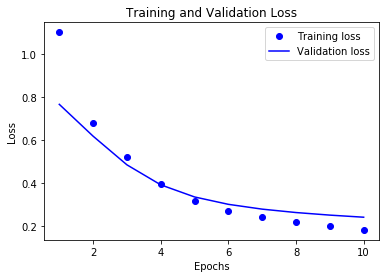

In [27]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo is for blue dot
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# b is for solid blue line
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('./images/model_loss.jpg')

plt.show()

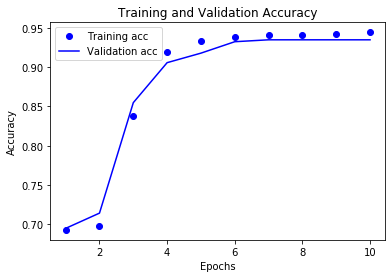

In [28]:
# bo is for blue dot
plt.plot(epochs, acc, 'bo', label = 'Training acc')
# b is for solid blue line
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('./images/model_accuracy.jpg')

plt.show()

## Export Model

In [29]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# test with raw_test_ds
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

83/83 [==============================] - 0s 728us/step - loss: 1.1435 - accuracy: 0.9479
0.9368932247161865


## Inference on new data

In [30]:
examples = [
    # https://www.winemag.com/buying-guide/far-niente-2018-cabernet-sauvignon-napa-valley/
    'This memorable Cabernet Sauvignon has small amounts of Petit Verdot, Cabernet Franc, Merlot and Malbec blended in. Aged 17 months in a majority of new French oak, it unfurls flavors of red fruit, dried herb and clove over a core of youthful tannin and spicy oak. Best from 2028–2038.',
    # https://www.winemag.com/buying-guide/wohlmuth-2018-ried-hochsteinriegl-sauvignon-blanc-sudsteiermark/
    'An initial hint of crushed ivy and citrus leaf peeks through on the nose. The palate then shows green-tinged ripeness, as if a juicy Mirabelle were spritzed with lime. All is bedded on a light-footed yet profound palate. It offers a gorgeous combination of smoothness and freshness. Drink by 2040. ANNE KREBIEHL MW',
    # https://www.winemag.com/buying-guide/g-h-mumm-2013-brut-millesime-champagne/
    'A Pinot Noir-dominated Champagne, this is richly textured and showing attractive signs of maturity. The toastiness is balanced by crispness with a tangy lemon flavor that broadens into ripe apples. Drink this seductive wine now. ROGER VOSS'
]

In [31]:
export_model.predict(examples)

array([[0.5005047 , 0.73017055, 0.50008994, 0.5002123 , 0.5003066 ,
        0.5000145 ],
       [0.5402482 , 0.54523635, 0.5084849 , 0.5373622 , 0.61306334,
        0.5033346 ],
       [0.5187206 , 0.5354397 , 0.5038636 , 0.52686787, 0.65843964,
        0.50092673]], dtype=float32)

## Save the file for use in classifier app
[Reference](https://www.tensorflow.org/tutorials/keras/save_and_load)

In [32]:
export_model.save('./model/wine_classifier', save_format='tf')

INFO:tensorflow:Assets written to: ./model/wine_classifier/assets
